In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate, hilbert, butter, filtfilt, iirnotch
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
import scipy.stats as stats
from scipy.spatial import cKDTree


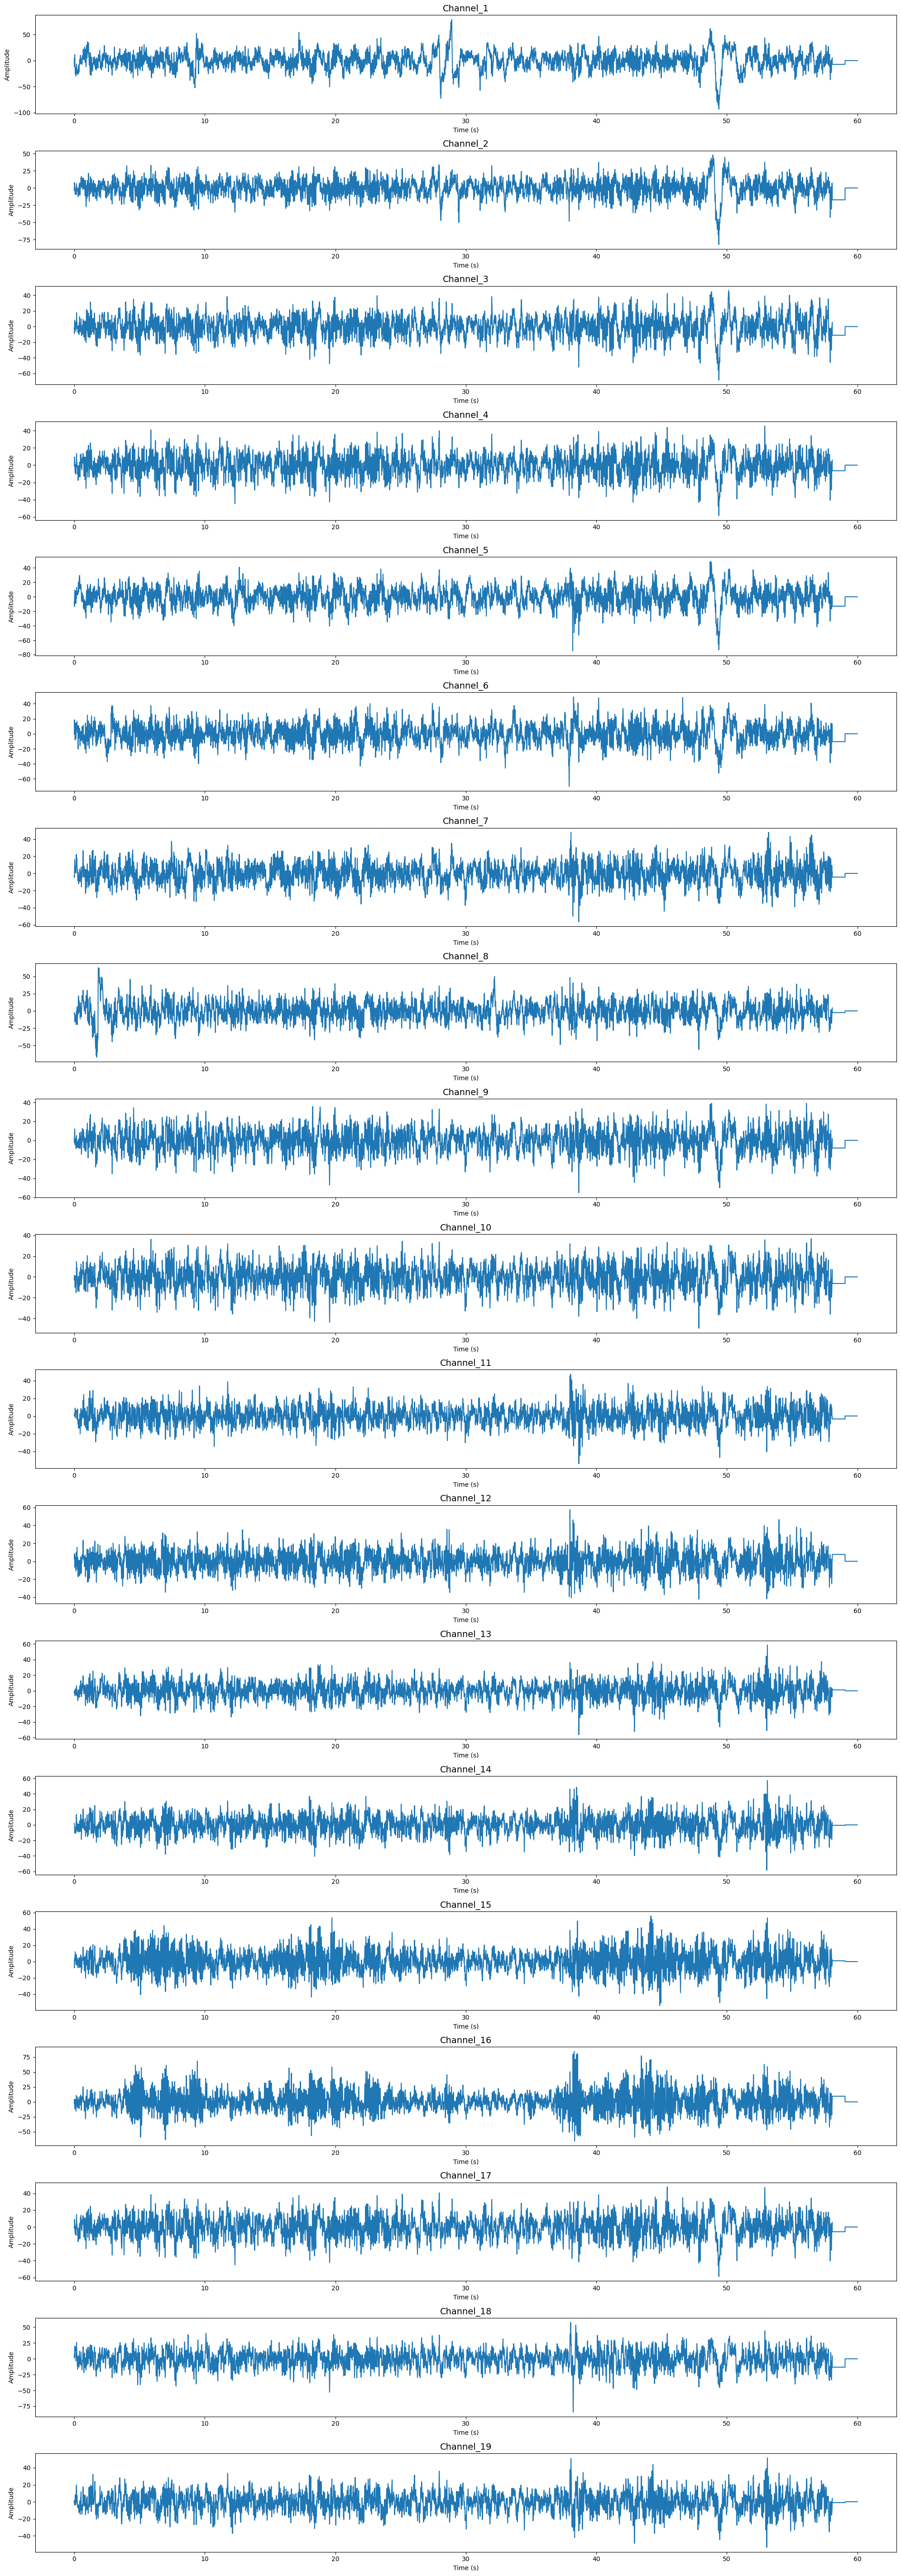

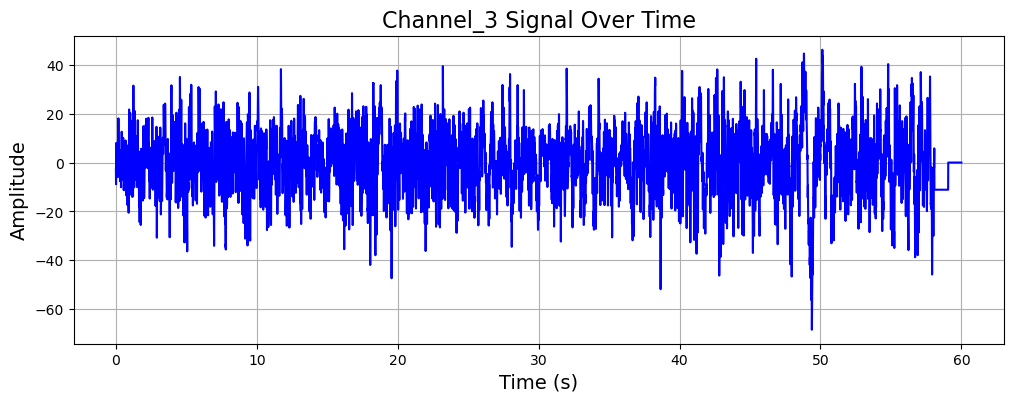

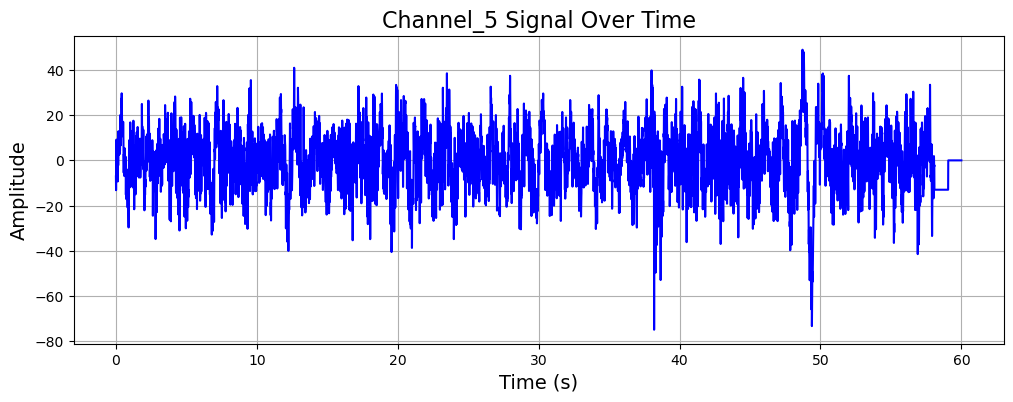

In [ ]:
#task 1.1 

data = pd.read_csv('s00.csv' , header=None)
channel_names = [f'Channel_{i+1}' for i in range(19)]
data.columns = channel_names
sampling_rate = 512
time_axis = np.linspace(0, 60, num=len(data))


plt.figure(figsize=(20, 3 * len(channel_names)))  

for i, channel in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(time_axis, data[channel])
    plt.title(channel, fontsize=14)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
plt.show()

channels_to_plot = ['Channel_3', 'Channel_5']  
for channel in channels_to_plot:
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, data[channel], color='blue')
    plt.title(f'{channel} Signal Over Time', fontsize=16)
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.grid()
    plt.show()



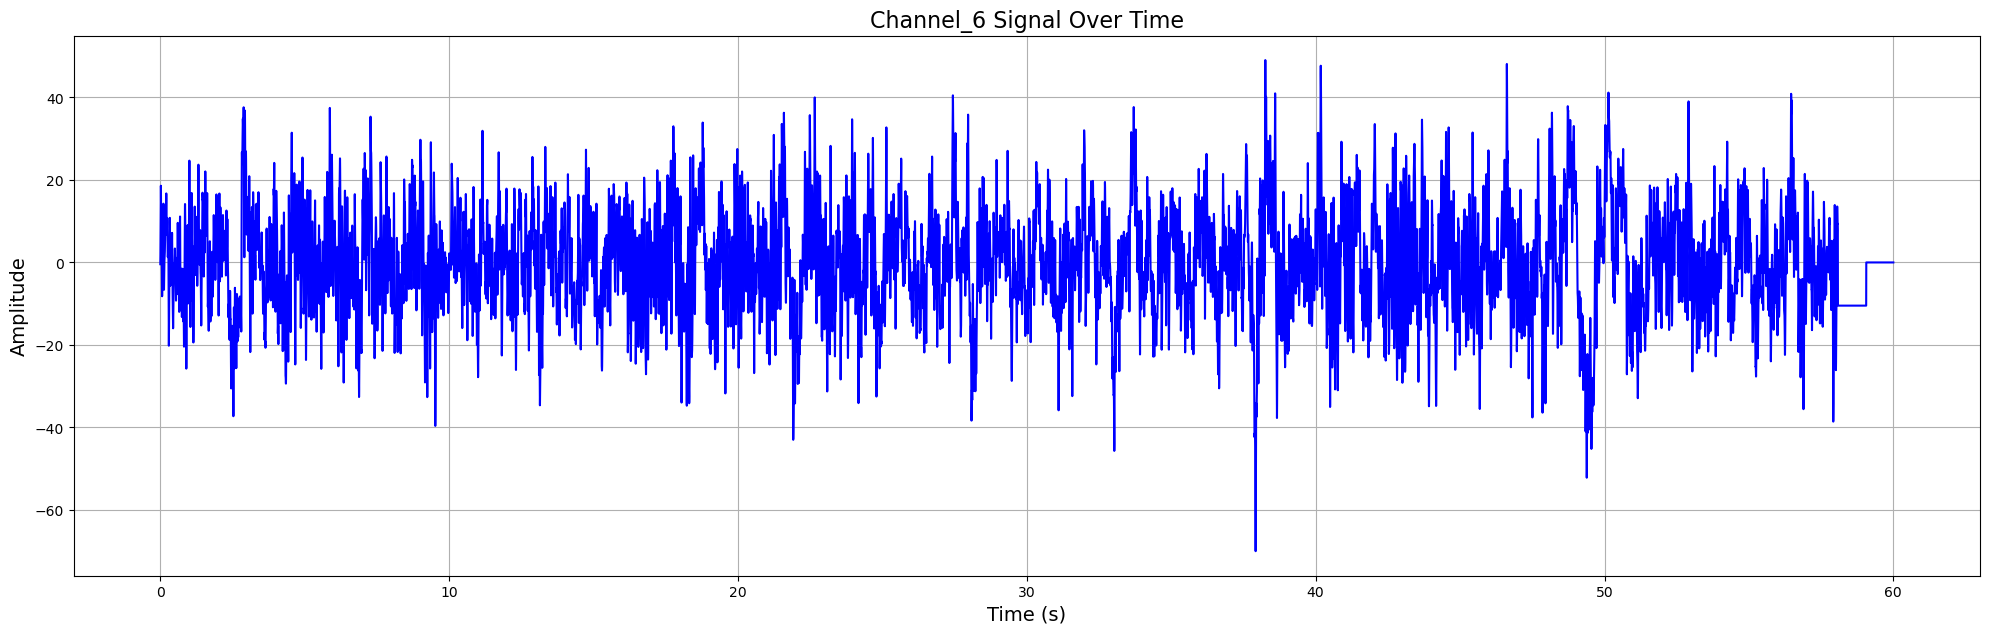

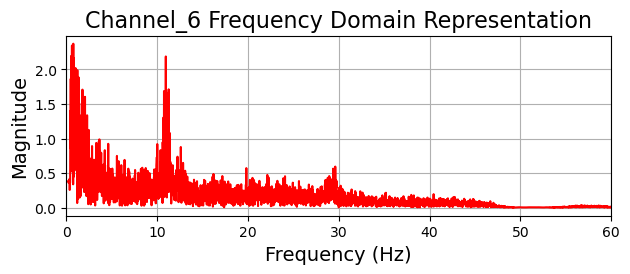

Dominant frequencies in Channel_6 (0-60 Hz): [10.95019355  0.54503226  0.69367742  0.61109677  0.75974194]
Frequency: 10.95 Hz, Magnitude: 2.19
Frequency: 0.55 Hz, Magnitude: 2.20
Frequency: 0.69 Hz, Magnitude: 2.23
Frequency: 0.61 Hz, Magnitude: 2.35
Frequency: 0.76 Hz, Magnitude: 2.37


In [16]:
#task 1.2
channel = 'Channel_6'
signal = data[channel].values
N = len(signal)
T = 1.0 / sampling_rate
yf = fft(signal)
xf = fftfreq(N, T)[:N//2]


plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
plt.plot(time_axis, signal, color='blue')
plt.title(f'{channel} Signal Over Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='red')
plt.xlim(0, 60)
plt.title(f'{channel} Frequency Domain Representation', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


magnitude = 2.0/N * np.abs(yf[0:N//2])
dominant_frequencies = xf[np.argsort(magnitude)[-5:]]
print(f'Dominant frequencies in {channel} (0-60 Hz): {dominant_frequencies}')

top_indices = np.argsort(magnitude)[-5:]
for i in top_indices:
    print(f'Frequency: {xf[i]:.2f} Hz, Magnitude: {magnitude[i]:.2f}')


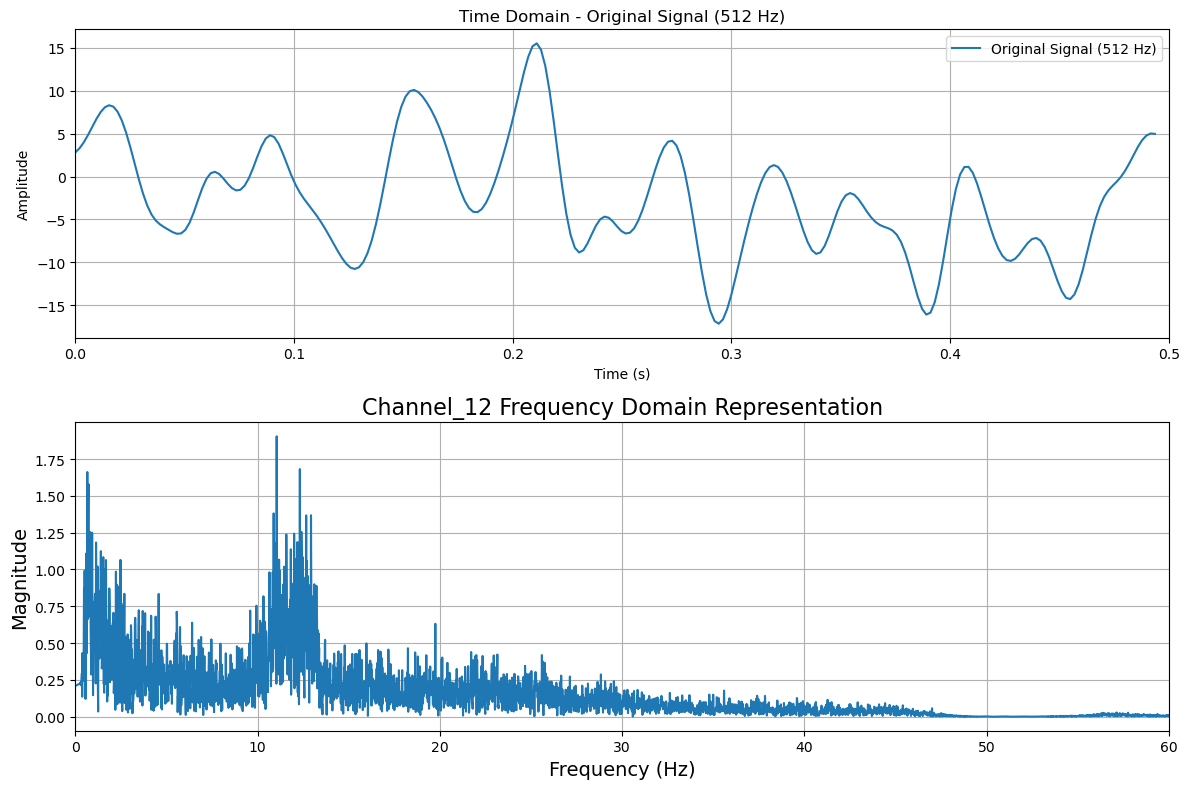

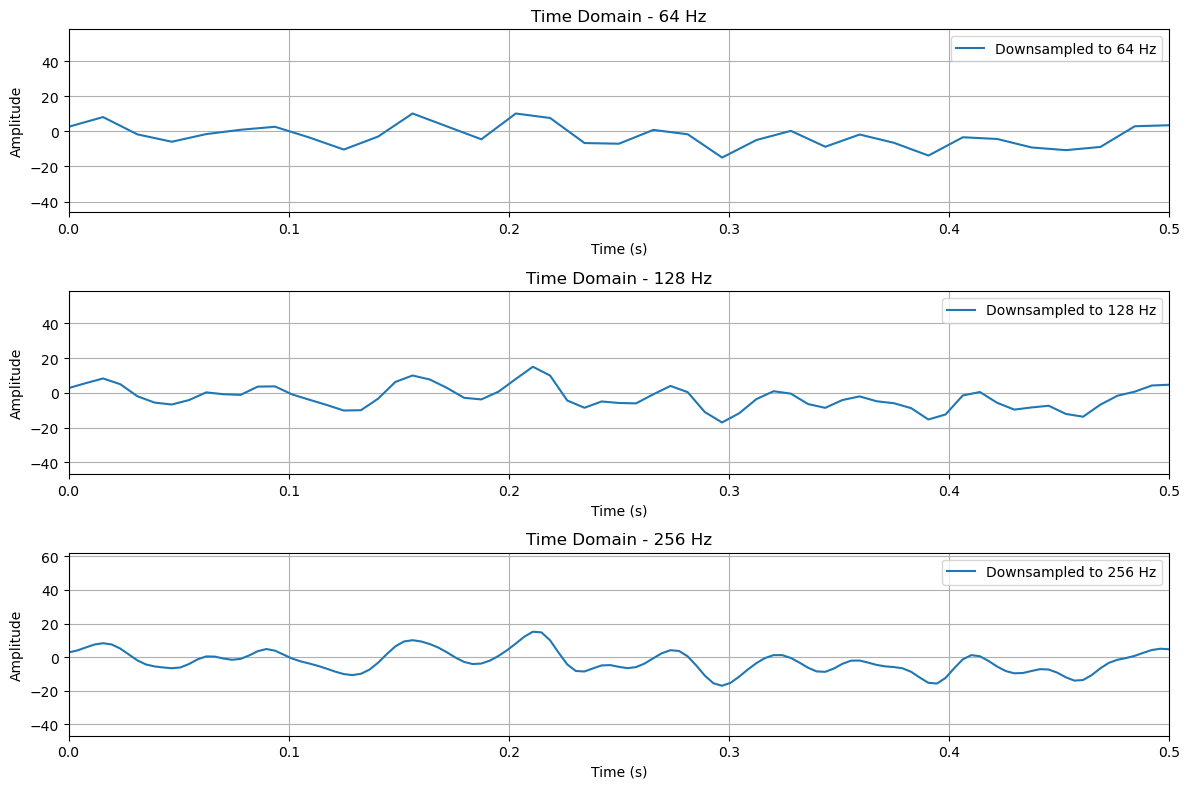

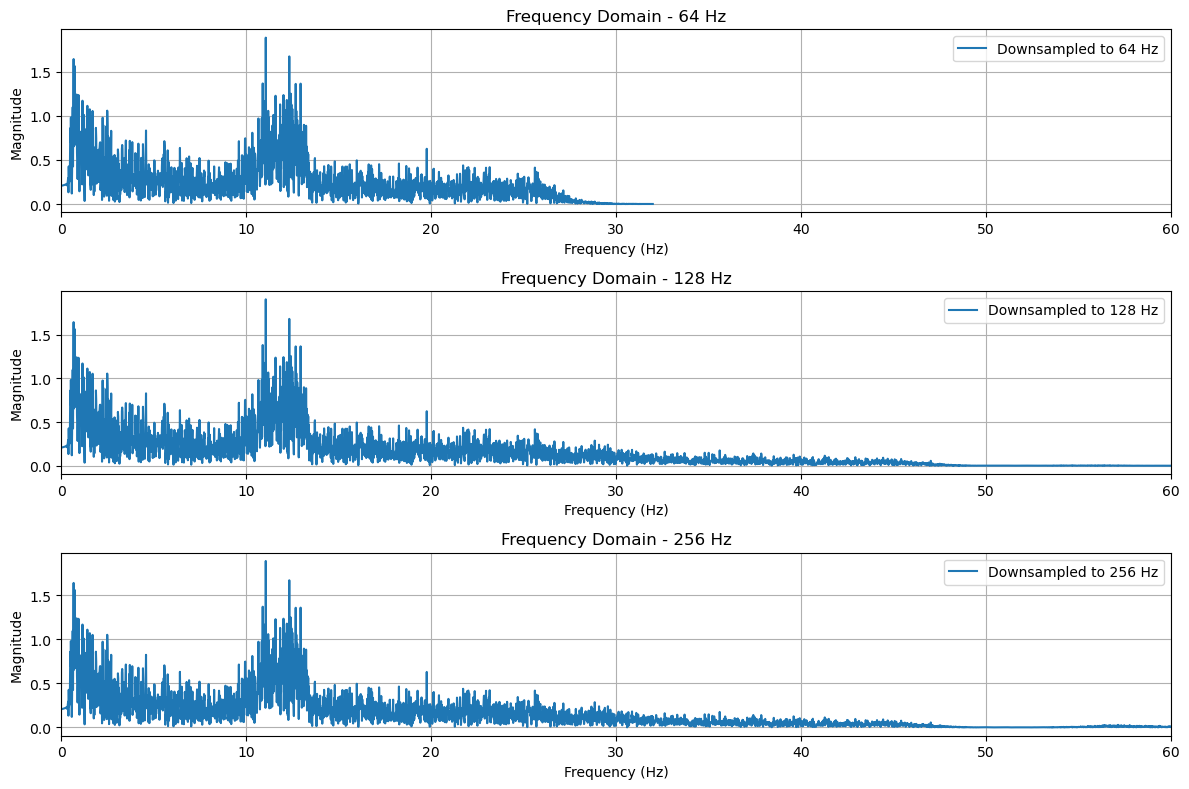

In [ ]:
#task 2.1

target_frequencies = [64, 128, 256]
downsampled_data = {}

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time_axis[:int(0.5 * sampling_rate)], data['Channel_12'][:int(0.5 * sampling_rate)], label='Original Signal (512 Hz)')
plt.xlim(0, 0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain - Original Signal (512 Hz)')
plt.legend()
plt.grid()


channel = 'Channel_12'
signal = data[channel].values
N = len(signal)
T = 1.0 / sampling_rate
yf = fft(signal)
xf = fftfreq(N, T)[:N//2]


plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 60)
plt.title(f'{channel} Frequency Domain Representation', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

for target_freq in target_frequencies:
    decimation_factor = sampling_rate // target_freq
    downsampled_signal = decimate(data['Channel_12'], decimation_factor)
    downsampled_time_axis = np.linspace(0, len(downsampled_signal) / target_freq, num=len(downsampled_signal))
    downsampled_data[target_freq] = (downsampled_time_axis, downsampled_signal)



plt.figure(figsize=(12, 8))
for target_freq, (time_axis, signal) in downsampled_data.items():
    plt.subplot(len(target_frequencies), 1, target_frequencies.index(target_freq) + 1)
    plt.plot(time_axis, signal, label=f'Downsampled to {target_freq} Hz')
    plt.xlim(0, 0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Time Domain - {target_freq} Hz')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for target_freq, (time_axis, signal) in downsampled_data.items():
    N = len(signal)
    T = 1.0 / target_freq
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(len(target_frequencies), 1, target_frequencies.index(target_freq) + 1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label=f'Downsampled to {target_freq} Hz')
    plt.xlim(0, 60)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Domain - {target_freq} Hz')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

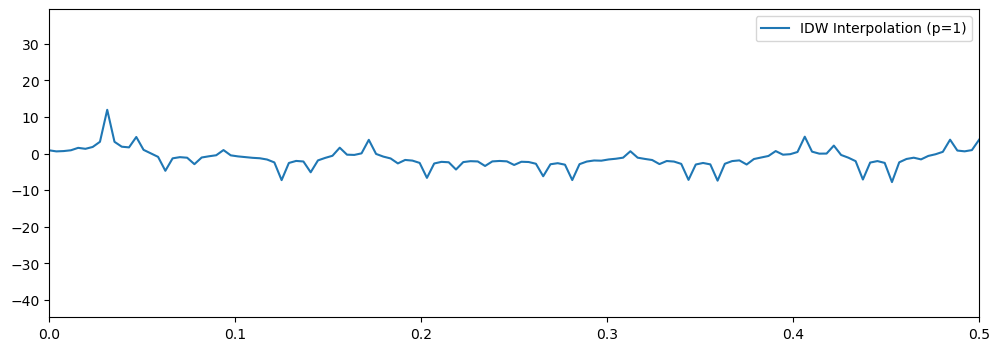

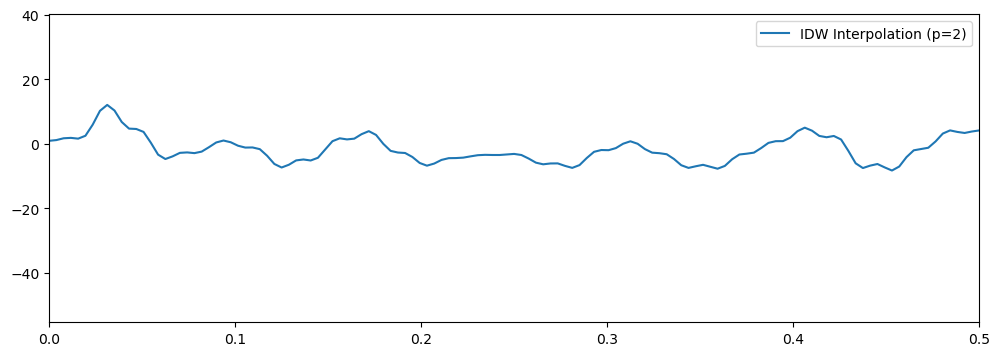

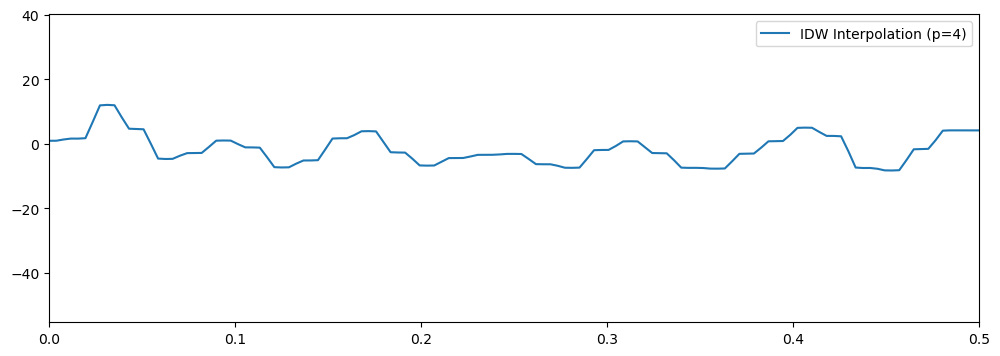

In [ ]:
#task 2.2

def idw_interpolation(xy_known, values_known, xy_unknown, power):
    tree = cKDTree(xy_known)
    distances, indices = tree.query(xy_unknown, k=len(xy_known), distance_upper_bound=np.inf)
    weights = 1 / (distances ** power + 1e-12)
    weights_sum = np.sum(weights, axis=1, keepdims=True)
    weights /= weights_sum
    interpolated_values = np.sum(weights * values_known[indices], axis=1)
    return interpolated_values

power_values = [1, 2, 4]

downsampled_freq = 64
decimation_factor = sampling_rate // downsampled_freq
downsampled_signal = decimate(data['Channel_9'], decimation_factor)
downsampled_time_axis = np.linspace(0, len(downsampled_signal) / downsampled_freq, num=len(downsampled_signal))
xy_known = np.array([[t, 0] for t in downsampled_time_axis])
values_known = downsampled_signal
xy_unknown = np.array([[t, 0] for t in time_axis])
interpolated_signals = {}
for power in power_values:
    interpolated_signal = idw_interpolation(xy_known, values_known, xy_unknown, power)
    interpolated_signals[power] = interpolated_signal
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, interpolated_signal, label=f'IDW Interpolation (p={power})')
    plt.xlim(0, 0.5)
    plt.legend()
    plt.show()



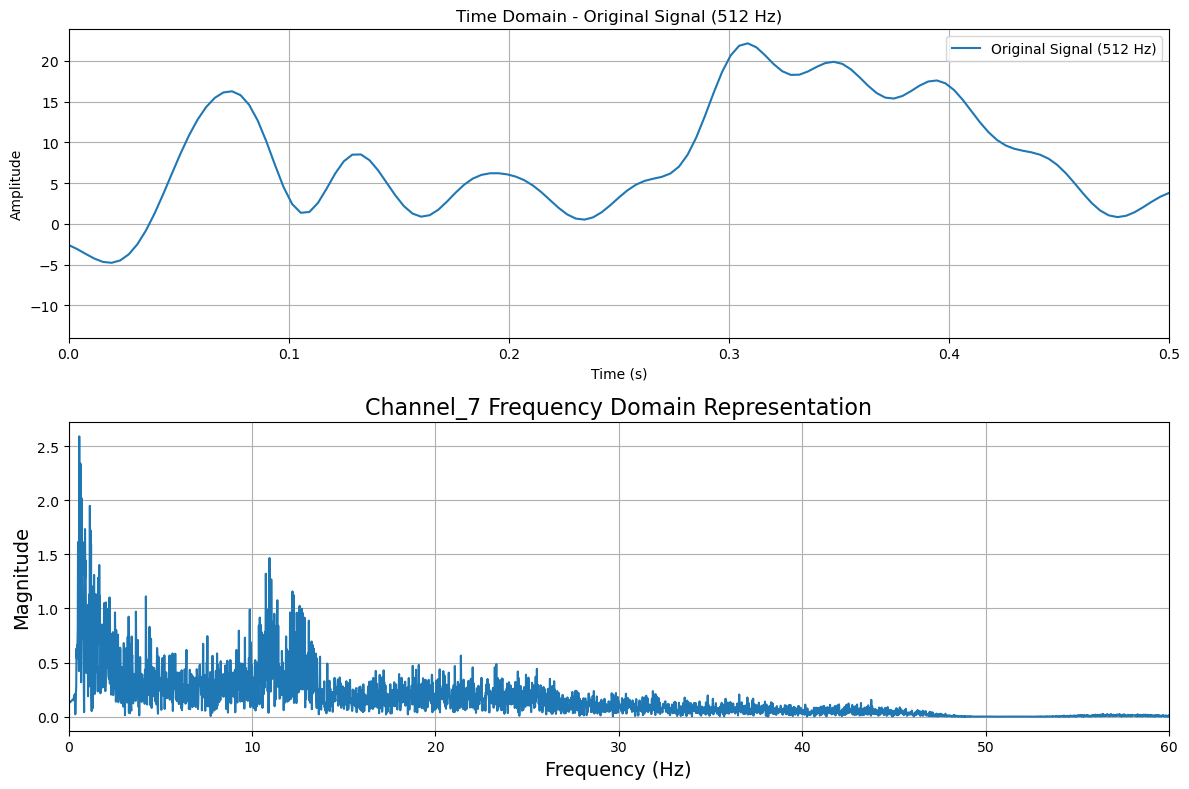

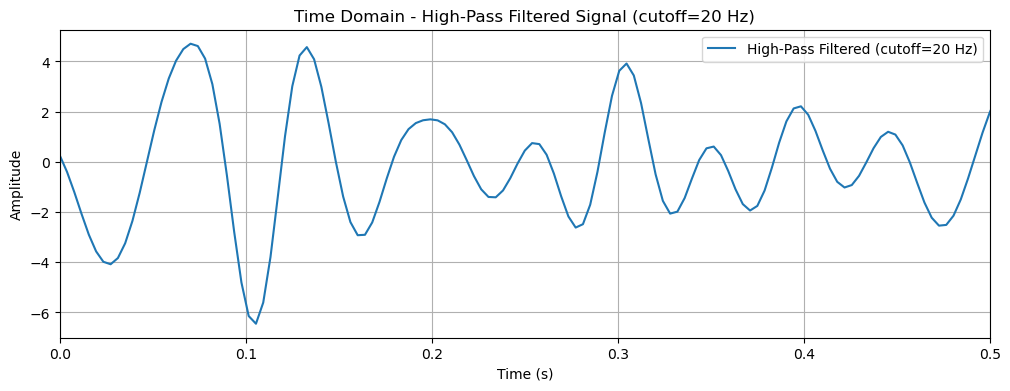

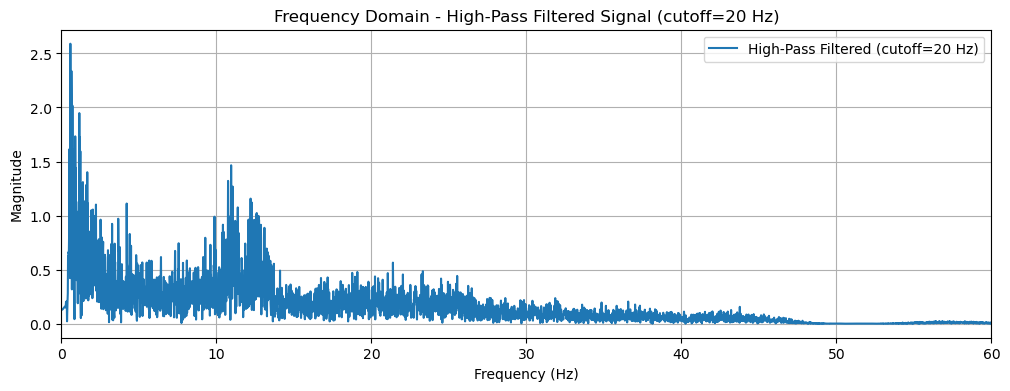

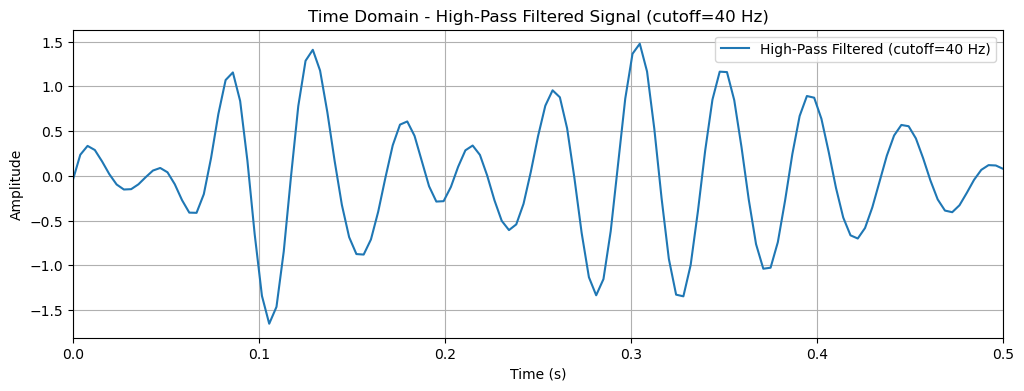

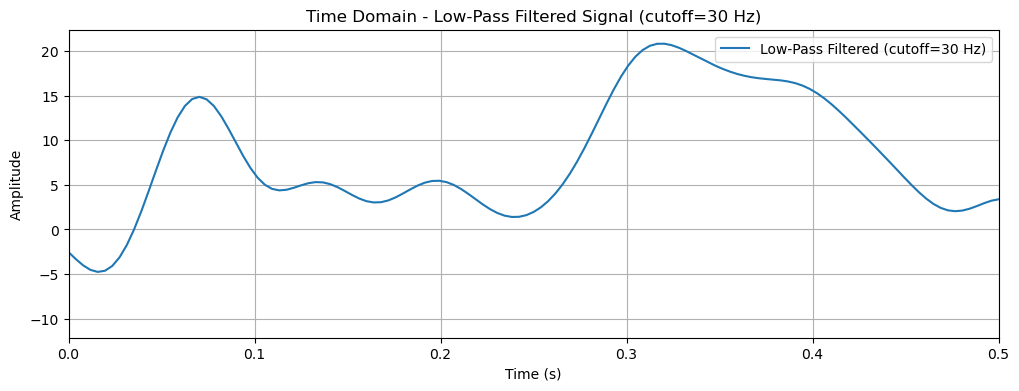

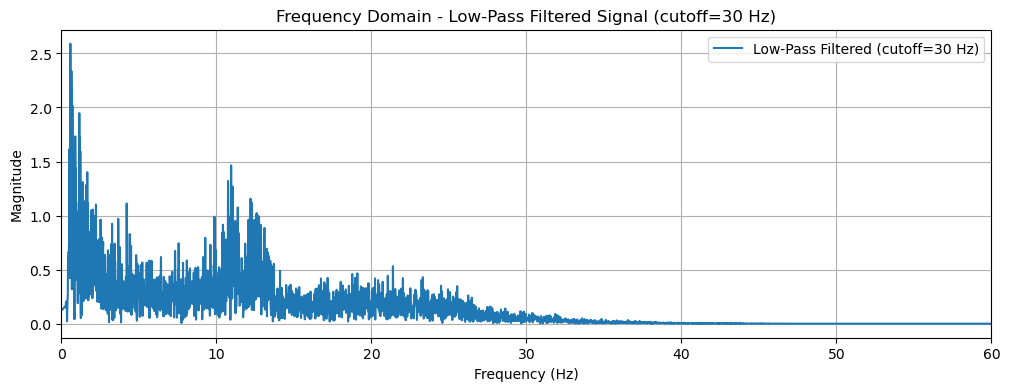

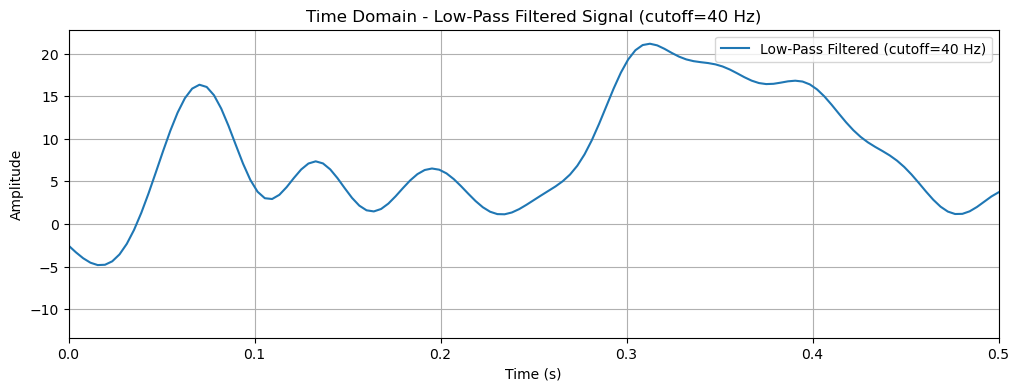

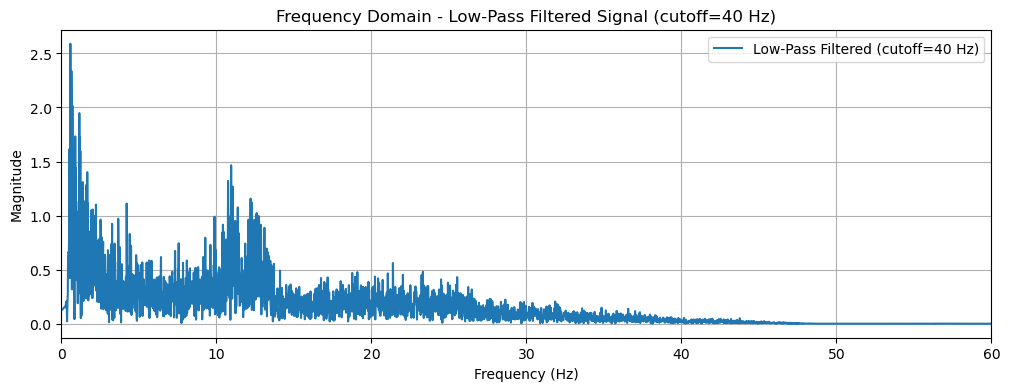

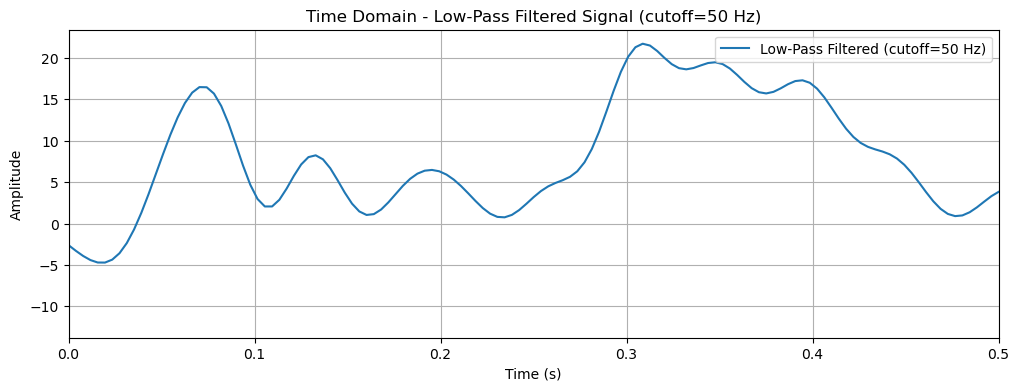

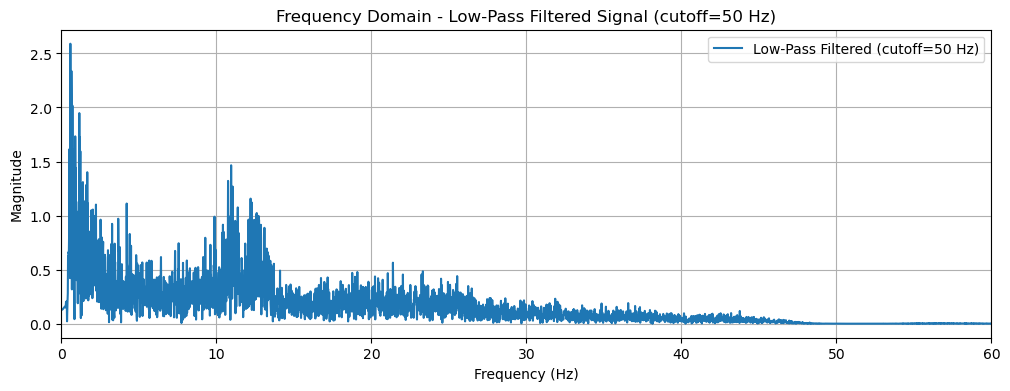

In [ ]:
#task 3.1

def butter_filter(data, cutoff, fs, order=4, btype='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequencies_hp = [20, 30, 40]
cutoff_frequencies_lp = [30, 40, 50]
channel = 'Channel_7'
original_signal = data[channel].values


plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time_axis[:int(0.5 * sampling_rate)], data['Channel_7'][:int(0.5 * sampling_rate)], label='Original Signal (512 Hz)')
plt.xlim(0, 0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain - Original Signal (512 Hz)')
plt.legend()
plt.grid()

channel = 'Channel_7'
signal = data[channel].values
N = len(signal)
T = 1.0 / sampling_rate
yf = fft(signal)
xf = fftfreq(N, T)[:N//2]


plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 60)
plt.title(f'{channel} Frequency Domain Representation', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


for cutoff in cutoff_frequencies_hp:
    filtered_signal = butter_filter(original_signal, cutoff, sampling_rate, order=4, btype='high')
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis[:int(0.5 * sampling_rate)], filtered_signal[:int(0.5 * sampling_rate)], label=f'High-Pass Filtered (cutoff={cutoff} Hz)')
    plt.xlim(0, 0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Time Domain - High-Pass Filtered Signal (cutoff={cutoff} Hz)')
    plt.legend()
    plt.grid()
    plt.show()
    

    plt.figure(figsize=(12, 4))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label=f'High-Pass Filtered (cutoff={cutoff} Hz)')
    plt.xlim(0, 60)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Domain - High-Pass Filtered Signal (cutoff={cutoff} Hz)')
    plt.legend()
    plt.grid()
    plt.show()

for cutoff in cutoff_frequencies_lp:
    filtered_signal = butter_filter(original_signal, cutoff, sampling_rate, order=4, btype='low')
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis[:int(0.5 * sampling_rate)], filtered_signal[:int(0.5 * sampling_rate)], label=f'Low-Pass Filtered (cutoff={cutoff} Hz)')
    plt.xlim(0, 0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Time Domain - Low-Pass Filtered Signal (cutoff={cutoff} Hz)')
    plt.legend()
    plt.grid()
    plt.show()
    
    N = len(filtered_signal)
    T = 1.0 / sampling_rate
    yf = fft(filtered_signal)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(12, 4))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label=f'Low-Pass Filtered (cutoff={cutoff} Hz)')
    plt.xlim(0, 60)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Domain - Low-Pass Filtered Signal (cutoff={cutoff} Hz)')
    plt.legend()
    plt.grid()
    plt.show()



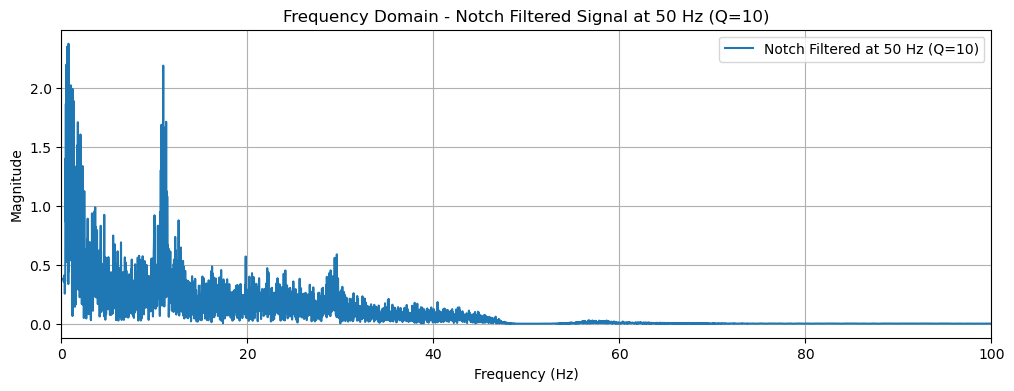

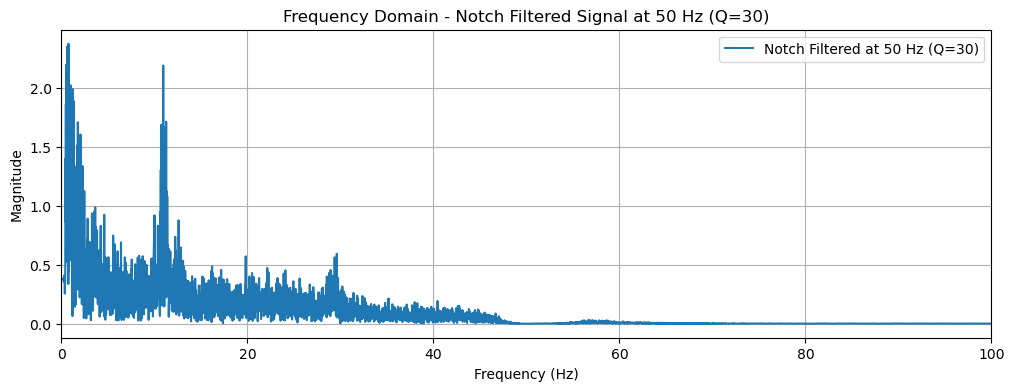

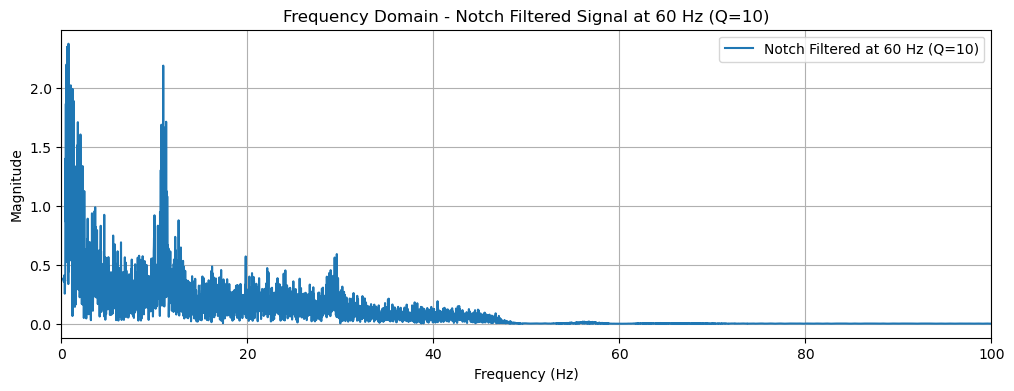

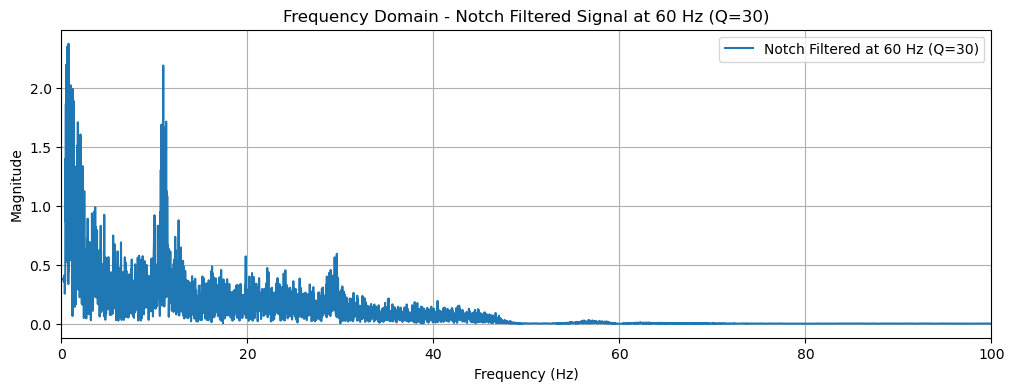

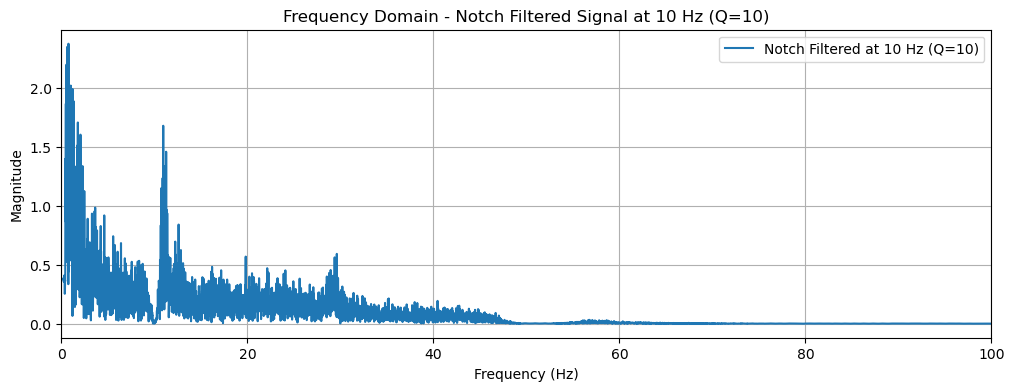

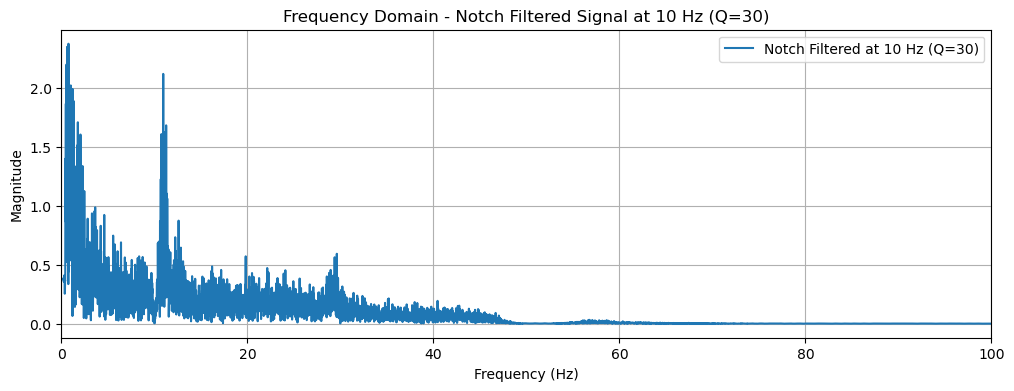

In [20]:
#task 3.2

def apply_notch_filter(data, fs, freq, Q):
    b, a = iirnotch(freq, Q, fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data
notch_frequencies = [50, 60, 10]
Q_values = [10, 30]
channel = 'Channel_6'
original_signal = data[channel].values
for freq in notch_frequencies:
    for Q in Q_values:
        filtered_signal = apply_notch_filter(original_signal, sampling_rate, freq, Q)
        N = len(filtered_signal)
        T = 1.0 / sampling_rate
        yf = fft(filtered_signal)
        xf = fftfreq(N, T)[:N//2]
        plt.figure(figsize=(12, 4))
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label=f'Notch Filtered at {freq} Hz (Q={Q})')
        plt.xlim(0, 100)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(f'Frequency Domain - Notch Filtered Signal at {freq} Hz (Q={Q})')
        plt.legend()
        plt.grid()
        plt.show()


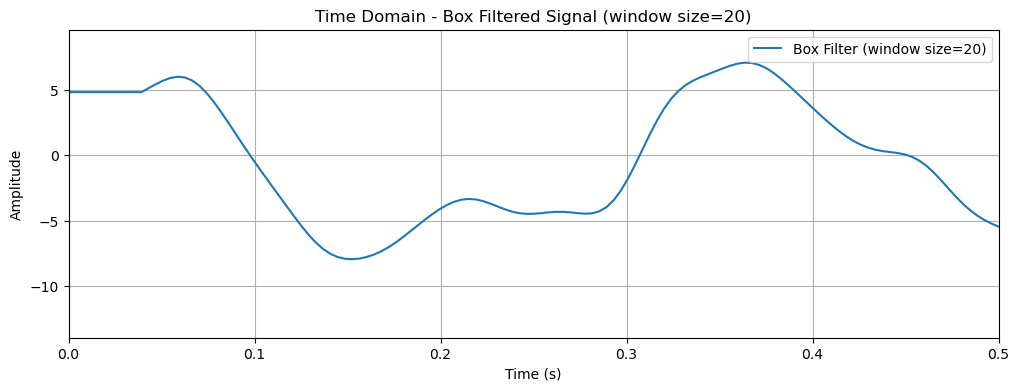

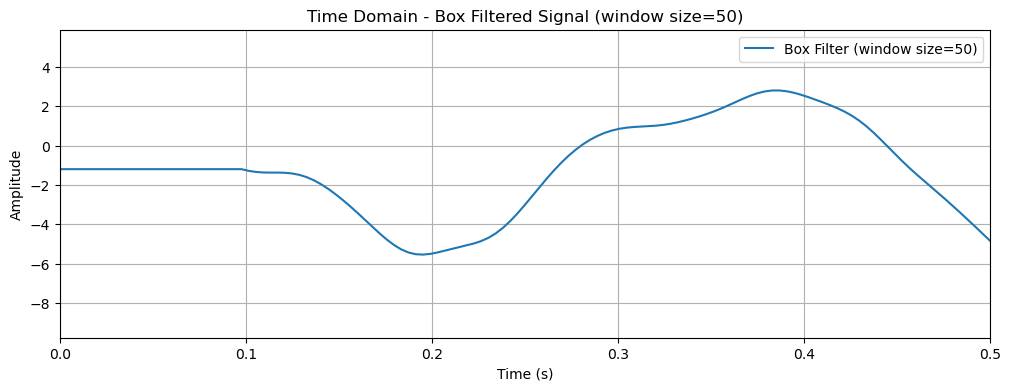

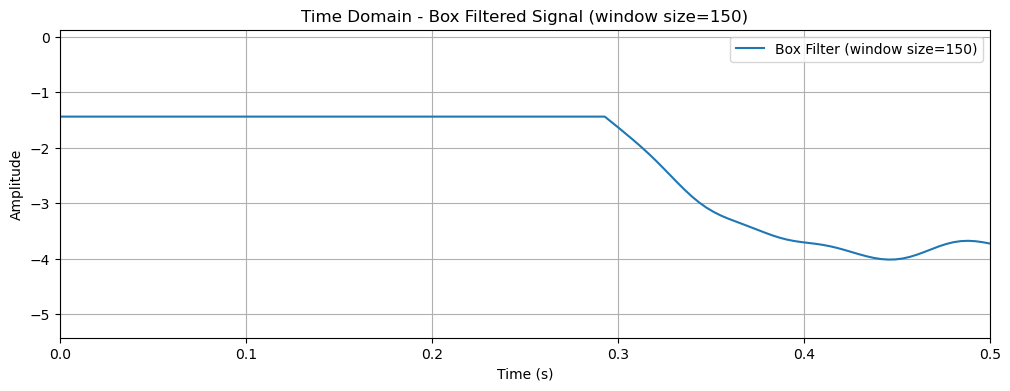

In [21]:
#task 4.1

def box_filter(signal, window_size):
    cumsum = np.cumsum(np.insert(signal, 0, 0)) 
    filtered_signal = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    pad_width = window_size // 2
    filtered_signal = np.pad(filtered_signal, (pad_width, window_size - pad_width - 1), mode='edge')
    return filtered_signal

window_sizes = [20, 50, 150]
channel = 'Channel_4'
original_signal = data[channel].values
for window_size in window_sizes:
    filtered_signal = box_filter(original_signal, window_size)
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis[:int(0.5 * sampling_rate)], filtered_signal[:int(0.5 * sampling_rate)], label=f'Box Filter (window size={window_size})')
    plt.xlim(0, 0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Time Domain - Box Filtered Signal (window size={window_size})')
    plt.legend()
    plt.grid()
    plt.show()
    

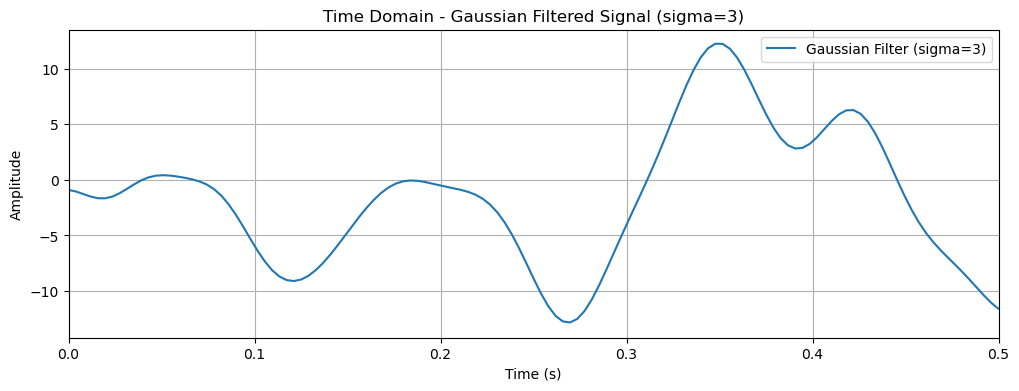

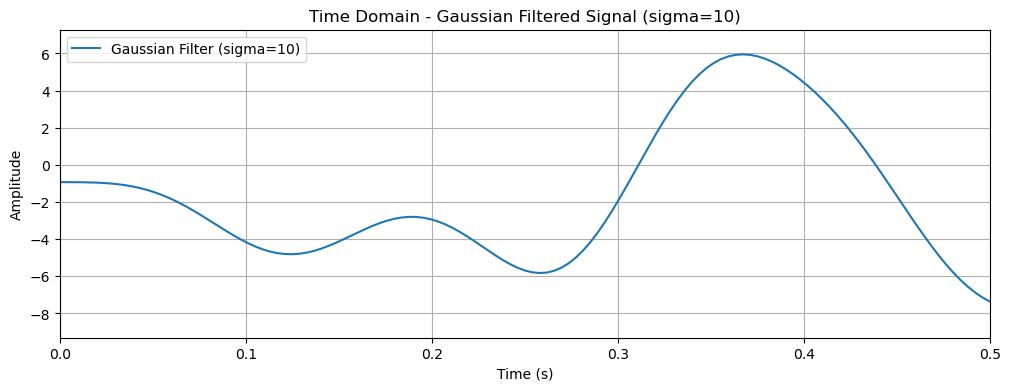

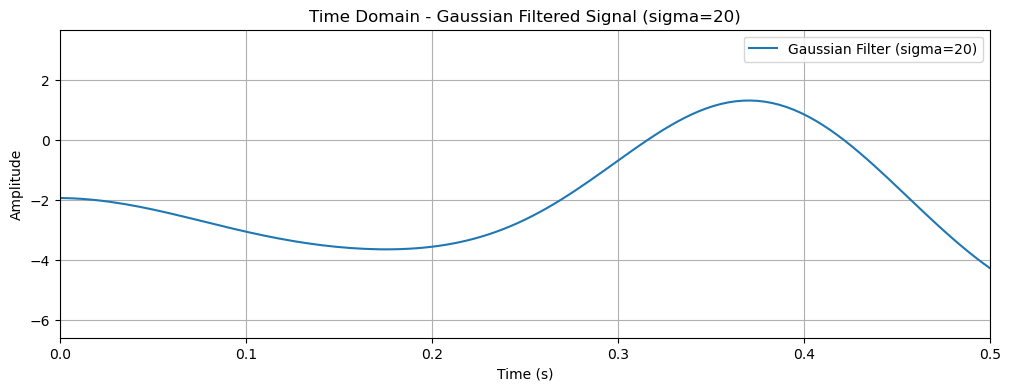

In [22]:
#task 4.2 

sigma_values = [3, 10, 20]
channel = 'Channel_10'
original_signal = data[channel].values
for sigma in sigma_values:
    filtered_signal = gaussian_filter1d(original_signal, sigma=sigma)
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis[:int(0.5 * sampling_rate)], filtered_signal[:int(0.5 * sampling_rate)], label=f'Gaussian Filter (sigma={sigma})')
    plt.xlim(0, 0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Time Domain - Gaussian Filtered Signal (sigma={sigma})')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
#task 5.1

def extract_features(signal):
    features = {}
    features['energy'] = np.sum(signal ** 2)
    features['rms'] = np.sqrt(np.mean(signal ** 2))
    features['peak'] = np.max(np.abs(signal))
    features['amplitude'] = (np.max(signal) - np.min(signal)) / 2
    features['skewness'] = stats.skew(signal)
    features['kurtosis'] = stats.kurtosis(signal)
    features['crest_factor'] = features['peak'] / features['rms']
    features['shape_factor'] = features['rms'] / np.mean(np.abs(signal))
    features['impulse_factor'] = features['peak'] / np.mean(np.abs(signal))
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    features['clearance_factor'] = features['peak'] / (np.mean(envelope) ** 2)
    prob_dist = np.abs(signal) / np.sum(np.abs(signal))
    features['shannon_entropy'] = -np.sum(prob_dist * np.log2(prob_dist + 1e-12))
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(signal)
    features['lempel_ziv_complexity'] = len(set(signal)) 
    features['fractal_dimension'] = 1.5  
    return features


channels_to_analyze = ['Channel_3', 'Channel_5', 'Channel_7']
feature_table = pd.DataFrame()
for channel in channels_to_analyze:
    signal = data[channel].values
    features = extract_features(signal)
    feature_table[channel] = pd.Series(features)
print(feature_table)

                          Channel_3     Channel_5     Channel_7
energy                 5.193276e+06  5.225482e+06  4.162563e+06
rms                    1.294315e+01  1.298322e+01  1.158776e+01
peak                   6.840600e+01  7.495800e+01  5.665700e+01
amplitude              5.728550e+01  6.196950e+01  5.231900e+01
skewness              -1.494945e-01 -2.513666e-01 -1.898850e-02
kurtosis               7.148992e-01  1.049683e+00  4.193465e-01
crest_factor           5.285114e+00  5.773453e+00  4.889382e+00
shape_factor           1.284916e+00  1.286880e+00  1.278016e+00
impulse_factor         6.790926e+00  7.429742e+00  6.248707e+00
clearance_factor       2.716702e-01  2.961109e-01  2.770362e-01
shannon_entropy        1.446799e+01  1.446938e+01  1.447481e+01
zero_crossing_rate     3.964516e-02  4.038710e-02  4.283871e-02
lempel_ziv_complexity  1.774000e+04  1.744100e+04  1.747900e+04
fractal_dimension      1.500000e+00  1.500000e+00  1.500000e+00


In [24]:
#task 5.2


channel = 'Channel_3'
original_signal = data[channel].values
high_passed_signal = butter_filter(original_signal, 30, sampling_rate, order=4, btype='high')
low_passed_signal = butter_filter(original_signal, 30, sampling_rate, order=4, btype='low')
notch_filtered_signal = apply_notch_filter(original_signal, sampling_rate, 40, 30)
signal_versions = {'Original': original_signal,
                   'High-Pass Filtered': high_passed_signal,
                   'Low-Pass Filtered': low_passed_signal,
                   'Notch Filtered': notch_filtered_signal}


feature_table_2 = pd.DataFrame()
for version_name, signal in signal_versions.items():
    features = extract_features(signal)
    feature_table_2[version_name] = pd.Series(features)
print(feature_table_2)


                           Original  High-Pass Filtered  Low-Pass Filtered  \
energy                 5.193276e+06        54487.547792       5.031723e+06   
rms                    1.294315e+01            1.325769       1.274024e+01   
peak                   6.840600e+01            8.352778       6.630171e+01   
amplitude              5.728550e+01            8.329381       5.526039e+01   
skewness              -1.494945e-01            0.005042      -1.492259e-01   
kurtosis               7.148992e-01            0.722026       7.377959e-01   
crest_factor           5.285114e+00            6.300328       5.204119e+00   
shape_factor           1.284916e+00            1.287217       1.285143e+00   
impulse_factor         6.790926e+00            8.109887       6.688034e+00   
clearance_factor       2.716702e-01            3.189296       2.720748e-01   
shannon_entropy        1.446799e+01           14.452204       1.446840e+01   
zero_crossing_rate     3.964516e-02            0.131710       3.